<a href="https://colab.research.google.com/github/krisz17/variational_autoencoder_for_similarity/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# tutorial do importu danych https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235
# https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8

# zapisywanie modeli w colab
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=m2dkmJVCGUia

# instaluję moduł kaggle oraz tworzę katalog na klucz
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
# importuję klucz, należy wejść na swoje konto kaggle, zakładka account i na wysokości "API" wygenrować nowy token key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krzysiekzdanowicz","key":"ef2ab400bc4fdc70f13b346bf97df930"}'}

In [3]:
# kopiuję klucz z kaggle do katalogu
!cp kaggle.json ~/.kaggle/

In [ ]:
# w ten sposób wyświetlamy wszystkie dostępne zbiory danych
!kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
zusmani/pakistan-toshakhana-files                                  Pakistan ToshaKhana Files                             1MB  2023-03-15 16:25:43           2387        113  1.0              
ramkrijal/tomato-daily-prices                                      Tomato Daily Prices                                  10KB  2023-03-10 15:39:14           1452         47  1.0              
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                      8KB  2023-02-01 12:22:51          14857        479  1.0              
datascientistanna/customers-dataset          

In [4]:
# importuję celeb-dataset bezpośrednio na dysk colab
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:11<00:00, 81.2MB/s]
100% 1.33G/1.33G [00:11<00:00, 120MB/s] 


In [ ]:
#from google.colab import files
#uploaded = files.upload()

Saving weights.h5 to weights.h5


In [5]:
# definiowanie struktury projektu
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

In [6]:
# import wymaganych bibliotek
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

In [7]:
# ze względu na bardzo duży rozmiar zbioru danych będą one wrzucane do treningu bachami
# niestety ten element kuleje na stacji roboczej i nie udało mi się tego naprawić

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
# prints : Total number of images : 202599


INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Total number of images : 202599
Found 202599 images belonging to 1 classes.


In [17]:
BATCH_SIZE = 1024

Topologia modelu. Zrobię najpierw tak jak pokazuje artykuł, w drugiej kolejności dorzucę węzły z książki

In [8]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
                    kernel_size = conv_kernel_size[i],
                    strides = conv_strides[i], 
                    padding = 'same',
                    name = 'encoder_conv_' + str(i)
                    )(x)

        # zdenek - dodanie normalizacji
        x = BatchNormalization()(x)
        # koniec zdenek

        x = LeakyReLU()(x)

        # zdenek - dorzucam warstwę dropout
        x = Dropout(rate = 0.25)(x)
        # koniec zdenek

    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 

    x = Flatten()(x)

    # Define model output
    encoder_output = Dense(output_dim, name = 'encoder_output')(x)

    return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                output_dim = Z_DIM, 
                                conv_filters = [32, 64, 64, 64],
                                conv_kernel_size = [3,3,3,3],
                                conv_strides = [2,2,2,2])

In [9]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(filters = conv_filters[i], 
                    kernel_size = conv_kernel_size[i],
                    strides = conv_strides[i], 
                    padding = 'same',
                    name = 'decoder_conv_' + str(i)
                    )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = BatchNormalization()(x)
            x = LeakyReLU()(x)
            x = Dropout(rate = 0.25)(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )

In [10]:
# połaczenie autoencodera z dekoderem

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                           

In [26]:
# kompilacja i trenowanie
LEARNING_RATE = 0.0005
N_EPOCHS = 1

optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=optimizer, loss = r_loss)

checkpoint_ae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.h5'), save_weights_only = True, verbose=1)

simple_autoencoder.fit_generator(data_flow, 
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 initial_epoch = 0, 
                                 steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                                 callbacks=[checkpoint_ae])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-26-efd5f1b88aa8>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  simple_autoencoder.fit_generator(data_flow,


198/197 [==============================] - ETA: -2s - loss: 0.0091
Epoch 1: saving model to ./weights/AE/weights.h5
197/197 [==============================] - 3203s 16s/step - loss: 0.0091


In [ ]:
# zapisanie modeu 
!mkdir -p saved_model
simple_autoencoder.save('saved_model/ae')

#sprawdzenie struktury
!ls saved_model


ae


In [ ]:
# czy zawiera ae.pb oraz potrzebne foldery assetrs, variables
!ls saved_model/ae

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [ ]:
# załadowanie modelu
simple_autoencoder3 = tf.keras.models.load_model('saved_model/ae')

# sprawdzenie architektury
simple_autoencoder3.summary()


ValueError: ignored

In [ ]:
# ocena modelu 
loss, acc = simple_autoencoder.evaluate(testowe_foto, testowe_labelki, verbose=2)

In [27]:
# druga metoda to zapisanie modelu do formatu 
simple_autoencoder.save('ae_model5e.h5')

In [11]:
# zapisany model został przerzucony na dysk twardy. Tutaj go przerzucam spowrotem do 
from google.colab import files
uploaded = files.upload()

Saving ae_model3e.h5 to ae_model3e.h5


In [13]:
import tensorflow as tf
from tensorflow import keras
# zaczytanie modelu wczytanego drugą metodą. Muszę sprawdzić gdzie się zapisał i dodać tutaj ścieżkę!

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

#simple_autoencoder2 = tf.keras.models.load_model('ae_model.h5', custom_objects={ 'loss': r_loss()})
simple_autoencoder = tf.keras.models.load_model('ae_model3e.h5', compile=False)

simple_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                           

1/1 [==============================] - 0s 308ms/step


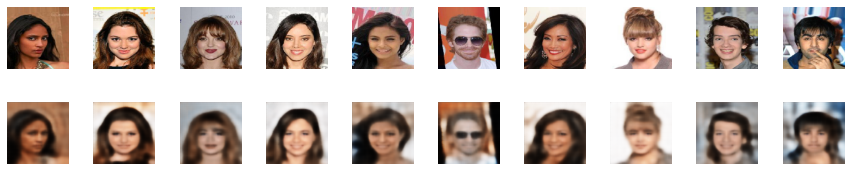

In [28]:
# porównanie zdjęć do rekonstrukcji

import matplotlib.pyplot as plt

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

def plot_compare(images=None, add_noise=False):
  
    if images is None:
        example_batch = next(data_flow)
        example_batch = example_batch[0]
        images = example_batch[:10]

    n_to_show = images.shape[0]

    if add_noise:
        encodings = encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = decoder.predict(encodings)

    else:
        reconst_images = simple_autoencoder.predict(images)

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img)  

plot_compare(example_images)      

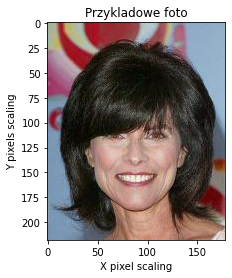

In [ ]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt

plt.title("Przykladowe foto")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
image = mpimg.imread(filenames[100000].squeeze())
plt.imshow(image)
plt.show()

In [29]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image

# Define image dimensions and number of channels
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

test_folder = './test_data/'

img_files = os.listdir(test_folder)

#na liście jest element ukryty, którego należy się pozbyć
#try:
#    del img_files[img_files.index('.ipynb_checkpoints')]

# Create an array to store the images
images = np.zeros((len(img_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Loop through each image file and load it into the array
for i, file in enumerate(img_files):
    img = Image.open(os.path.join(test_folder, file))
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    images[i] = np.array(img)

# Normalize the pixel values between 0 and 1
images = images / 255.0

1/1 [==============================] - 0s 83ms/step


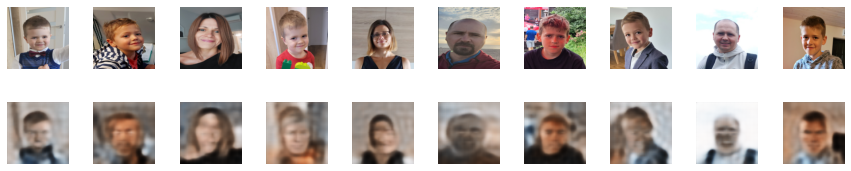

In [30]:
import matplotlib.pyplot as plt

reconst_images = simple_autoencoder.predict(images)
n_to_show = images.shape[0]

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)  


In [31]:
Jasiek = images[[0,5],:,:,:]
Antek = images[[3,6],:,:,:]
Piotr = images[[1,2],:,:,:]
Mama = images[[4,9],:,:,:]
Tata = images[[7,8],:,:,:]

rodzinka = ['Jasiek','Antek','Piotr','Mama','Tata']



In [33]:
from scipy.spatial import distance
import pandas as pd
enc_Jasiek = encoder.predict(Jasiek)
enc_Antek = encoder.predict(Antek)
enc_Piotr = encoder.predict(Piotr)
enc_Mama = encoder.predict(Mama)
enc_Tata = encoder.predict(Tata)


Mama_Jasiek = distance.cdist(enc_Mama,enc_Jasiek).min()
Mama_Antek = distance.cdist(enc_Mama,enc_Antek).min()
Mama_Piotr = distance.cdist(enc_Mama,enc_Piotr).min()

Tata_Jasiek = distance.cdist(enc_Tata,enc_Jasiek).min()
Tata_Antek = distance.cdist(enc_Tata,enc_Antek).min()
Tata_Piotr = distance.cdist(enc_Tata,enc_Piotr).min()

odleglosci = [('Jasiek', Mama_Jasiek, Tata_Jasiek),
              ('Antek',  Mama_Antek,  Tata_Antek),
              ('Piotr',  Mama_Piotr,  Tata_Piotr)]

odleglosci_df = pd.DataFrame(odleglosci, columns = ['Dziecko', 'Mama', 'Tata'])
odleglosci_df

1/1 [==============================] - 0s 30ms/step


,Dziecko,Mama,Tata
0,Jasiek,0.221327,0.269022
1,Antek,0.257194,0.309911
2,Piotr,0.282736,0.337031


In [ ]:
# pętla z progres barem, może się przydać
from tqdm import tqdm
for i in tqdm(range(10000)):
    ...